# 实验四：中国股市收益率可预测性实证研究

## 数据处理

In [1]:
import numpy as np
import pandas as pd
from math import pi

import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

from sklearn import linear_model

In [2]:
data = pd.read_excel('../../实验四/assets/data/1EData_PredictorData2019.xlsx', sheet_name='Monthly')
data

d:\anaconda\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,yyyymm,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,csp,CRSP_SPvw,CRSP_SPvwx,PPIG,IPG
0,187101,4.440000,0.260000,0.40,NaN,NaN,NaN,NaN,NaN,NaN,0.004967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,187102,4.500000,0.260000,0.40,NaN,NaN,NaN,NaN,NaN,NaN,0.004525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,187103,4.610000,0.260000,0.40,NaN,NaN,NaN,NaN,NaN,NaN,0.004252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,187104,4.740000,0.260000,0.40,NaN,NaN,NaN,NaN,NaN,NaN,0.004643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,187105,4.860000,0.260000,0.40,NaN,NaN,NaN,NaN,NaN,NaN,0.003698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1783,201908,2926.459961,56.838763,133.69,0.237917,0.0210,0.0298,0.0387,0.0163,-0.010244,0.001625,-0.000051,0.0797,0.0738,0.004318,NaN,-0.016085,-0.018377,-0.747384,0.705045
1784,201909,2976.739990,57.219507,132.90,0.233377,0.0195,0.0303,0.0391,0.0170,-0.010959,0.001575,0.000783,-0.0192,-0.0190,0.000605,NaN,0.018791,0.017272,-0.401606,-0.347551
1785,201910,3037.560059,57.559879,135.09,0.232261,0.0189,0.0301,0.0392,0.0171,-0.013267,0.001375,0.002286,-0.0052,0.0006,0.001510,NaN,0.021621,0.020441,0.100806,-0.406952
1786,201911,3140.979980,57.900251,137.28,0.223938,0.0165,0.0306,0.0394,0.0181,-0.007907,0.001283,-0.000536,-0.0059,0.0014,0.000306,NaN,0.036206,0.033979,0.201410,0.928027


特征工程：创建新的预测变量

In [3]:
# DP（股息收益率）：股息与价格之比的对数，计算公式为 log(D12) - log(Index)
data['DP'] = np.log(data['D12']) - np.log(data['Index'])

# EP（收益价格比）：收益与价格之比的对数，计算公式为 log(E12) - log(Index)
data['EP'] = np.log(data['E12']) - np.log(data['Index'])

# VOL（波动率）：过去12个月市场回报绝对值的平均值乘以 √(π/2)，这是估计波动率的一种方法
data['VOL'] = data['CRSP_SPvw'].abs().rolling(window=12).mean()*np.sqrt(pi*6)

# BILL（短期国债相对价值）：短期国债收益率减去过去12个月平均值
data['BILL'] = data['tbl'] - data['tbl'].rolling(window=12).mean()

# BOND（长期国债相对价值）：长期国债收益率减去过去12个月平均值
data['BOND'] = data['lty'] - data['lty'].rolling(window=12).mean()

# TERM（期限利差）：长期国债收益率减去短期国债收益率
data['TERM'] = data['lty'] - data['tbl']

# CREDIT（信用利差）：AAA级债券收益率减去长期国债收益率
data['CREDIT'] = data['AAA'] - data['lty']

# MA112（12个月移动平均指标）：当前指数是否高于12个月移动平均值
data['MA112'] = data['Index'] >= data['Index'].rolling(window=12).mean()

# MA312（3-12个月移动平均指标）：3个月移动平均是否高于12个月移动平均
data['MA312'] = data['Index'].rolling(window=3).mean() >= data['Index'].rolling(window=12).mean()

# MOM6（6个月动量指标）：当前指数是否高于6个月前指数
data['MOM6'] = data['Index'] >= data['Index'].shift(periods=6)

# ExRet（超额收益率）：市场收益率减去无风险收益率
data['ExRet'] = data['CRSP_SPvw'] - data['Rfree']

# 将布尔型指标转换为0/1整数值
data[['MA112', 'MA312', 'MOM6']] = data[['MA112', 'MA312', 'MOM6']].astype(int)

data

,yyyymm,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,...,EP,VOL,BILL,BOND,TERM,CREDIT,MA112,MA312,MOM6,ExRet
0,187101,4.440000,0.260000,0.40,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.406945,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
1,187102,4.500000,0.260000,0.40,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.420368,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
2,187103,4.610000,0.260000,0.40,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.444519,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
3,187104,4.740000,0.260000,0.40,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.472328,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
4,187105,4.860000,0.260000,0.40,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.497329,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1783,201908,2926.459961,56.838763,133.69,0.237917,0.0210,0.0298,0.0387,0.0163,-0.010244,...,-3.086025,0.188374,-0.001725,-0.009958,-0.0047,0.0135,1,1,1,-0.017710
1784,201909,2976.739990,57.219507,132.90,0.233377,0.0195,0.0303,0.0391,0.0170,-0.010959,...,-3.108987,0.193314,-0.003158,-0.007892,-0.0025,0.0133,1,1,1,0.017216
1785,201910,3037.560059,57.559879,135.09,0.232261,0.0189,0.0301,0.0392,0.0171,-0.013267,...,-3.112869,0.176386,-0.003558,-0.006283,-0.0018,0.0130,1,1,1,0.020246
1786,201911,3140.979980,57.900251,137.28,0.223938,0.0165,0.0306,0.0394,0.0181,-0.007907,...,-3.130267,0.182339,-0.005458,-0.004150,0.0016,0.0125,1,1,1,0.034923


In [4]:
# 当期变量和滞后一期变量的组合数据集
# 这样可以用t-1期的变量预测t期的收益率
data = pd.concat(
    [data[['yyyymm', 'CRSP_SPvw', 'Rfree', 'ExRet',
            'DP', 'EP', 'VOL', 'BILL', 'BOND', 'TERM', 'CREDIT', 'PPIG', 'IPG',
            'MA112', 'MA312', 'MOM6']],
     data[['DP', 'EP', 'VOL', 'BILL', 'BOND', 'TERM', 'CREDIT', 'PPIG', 'IPG',
           'MA112', 'MA312', 'MOM6']].shift(periods=1)],
        axis=1)

data.columns = ['yyyymm', 'Ret', 'Rfree', 'ExRet',
                'DP', 'EP', 'VOL', 'BILL', 'BOND', 'TERM', 'CREDIT', 'PPIG', 'IPG',
                'MA112', 'MA312', 'MOM6', 'DPL1',
                'EPL1', 'VOLL1', 'BILLL1', 'BONDL1', 'TERML1', 'CREDITL1', 'PPIGL1', 'IPGL1',
                'MA112L1', 'MA312L1', 'MOM6L1']

data

,yyyymm,Ret,Rfree,ExRet,DP,EP,VOL,BILL,BOND,TERM,...,VOLL1,BILLL1,BONDL1,TERML1,CREDITL1,PPIGL1,IPGL1,MA112L1,MA312L1,MOM6L1
0,187101,NaN,0.004967,NaN,-2.837728,-2.406945,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,187102,NaN,0.004525,NaN,-2.851151,-2.420368,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,187103,NaN,0.004252,NaN,-2.875302,-2.444519,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,187104,NaN,0.004643,NaN,-2.903111,-2.472328,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,187105,NaN,0.003698,NaN,-2.928112,-2.497329,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1783,201908,-0.016085,0.001625,-0.017710,-3.941330,-3.086025,0.188374,-0.001725,-0.009958,-0.0047,...,0.194472,-0.000908,-0.006742,-0.0011,0.0123,0.199700,-0.175883,1.0,1.0,1.0
1784,201909,0.018791,0.001575,0.017216,-3.951689,-3.108987,0.193314,-0.003158,-0.007892,-0.0025,...,0.188374,-0.001725,-0.009958,-0.0047,0.0135,-0.747384,0.705045,1.0,1.0,1.0
1785,201910,0.021621,0.001375,0.020246,-3.965984,-3.112869,0.176386,-0.003558,-0.006283,-0.0018,...,0.193314,-0.003158,-0.007892,-0.0025,0.0133,-0.401606,-0.347551,1.0,1.0,1.0
1786,201911,0.036206,0.001283,0.034923,-3.993568,-3.130267,0.182339,-0.005458,-0.004150,0.0016,...,0.176386,-0.003558,-0.006283,-0.0018,0.0130,0.100806,-0.406952,1.0,1.0,1.0


In [5]:
# 筛选样本时间段并重置索引

# 筛选1927年1月及之后的数据
data = data[data['yyyymm'] >= 192701]
# 重置数据集的索引，使索引从0开始连续排列
data.reset_index(drop=True, inplace=True)

data

,yyyymm,Ret,Rfree,ExRet,DP,EP,VOL,BILL,BOND,TERM,...,VOLL1,BILLL1,BONDL1,TERML1,CREDITL1,PPIGL1,IPGL1,MA112L1,MA312L1,MOM6L1
0,192701,-0.002910,0.002692,-0.005602,-2.942374,-2.374773,0.133608,-0.001625,-0.001508,0.0044,...,0.133201,0.000808,-0.001400,0.0019,0.0114,-0.588235,-0.400104,1.0,1.0,1.0
1,192702,0.045522,0.002742,0.042780,-2.979535,-2.430353,0.138032,0.000192,-0.001700,0.0024,...,0.133608,-0.001625,-0.001508,0.0044,0.0115,-2.958580,-0.401711,1.0,1.0,1.0
2,192703,0.007324,0.002667,0.004657,-2.976535,-2.445079,0.119803,0.000700,-0.002967,0.0002,...,0.138032,0.000192,-0.001700,0.0024,0.0120,1.219512,0.806663,1.0,1.0,1.0
3,192704,0.013021,0.002825,0.010196,-2.984225,-2.471309,0.110576,-0.000250,-0.002475,0.0013,...,0.119803,0.000700,-0.002967,0.0002,0.0131,-0.602410,1.200312,1.0,1.0,1.0
4,192705,0.062353,0.002775,0.059578,-3.025963,-2.531446,0.128207,0.001392,-0.002725,-0.0012,...,0.110576,-0.000250,-0.002475,0.0013,0.0125,-1.212121,-2.372151,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,201908,-0.016085,0.001625,-0.017710,-3.941330,-3.086025,0.188374,-0.001725,-0.009958,-0.0047,...,0.194472,-0.000908,-0.006742,-0.0011,0.0123,0.199700,-0.175883,1.0,1.0,1.0
1112,201909,0.018791,0.001575,0.017216,-3.951689,-3.108987,0.193314,-0.003158,-0.007892,-0.0025,...,0.188374,-0.001725,-0.009958,-0.0047,0.0135,-0.747384,0.705045,1.0,1.0,1.0
1113,201910,0.021621,0.001375,0.020246,-3.965984,-3.112869,0.176386,-0.003558,-0.006283,-0.0018,...,0.193314,-0.003158,-0.007892,-0.0025,0.0133,-0.401606,-0.347551,1.0,1.0,1.0
1114,201911,0.036206,0.001283,0.034923,-3.993568,-3.130267,0.182339,-0.005458,-0.004150,0.0016,...,0.176386,-0.003558,-0.006283,-0.0018,0.0130,0.100806,-0.406952,1.0,1.0,1.0


<Axes: >

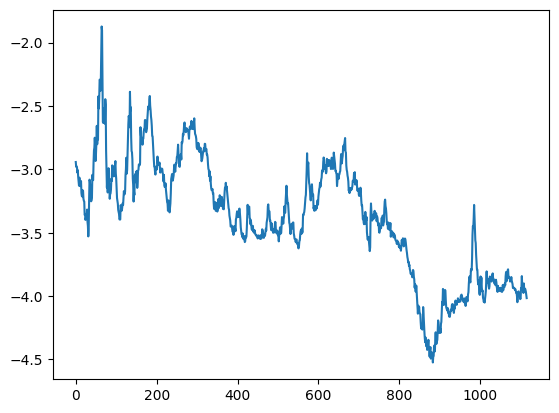

In [6]:
data['DP'].plot()

<Axes: >

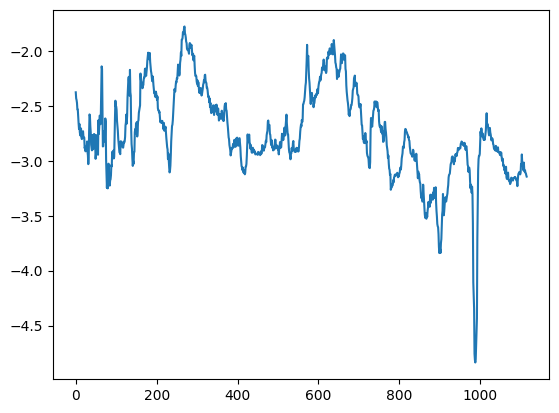

In [7]:
data['EP'].plot()

## 评估函数定义：统计与经济两方面

定义评估函数：统计收益

**样本外决定系数（Out-of-Sample R²）的计算**

$$
R^2_{os} = 1 - \frac{\sum_{t=1}^{T} (r_{t+1} - \hat{r}_{t+1})^2}{\sum_{t=1}^{T} (r_{t+1} - \bar{r}_{t+1})^2}
$$

其中：

- $r_{t+1}$ 是实际观测到的收益率（`rreal`）
- $\hat{r}_{t+1}$ 是预测模型预测的收益率（`rout`）
- $\bar{r}_{t+1}$ 是历史平均模型预测的收益率（`rmean`）

解释与意义：

- 分子 $\sum (r_{t+1} - \hat{r}_{t+1})^2$ 是预测模型的均方预测误差（MSPE）
- 分母 $\sum (r_{t+1} - \bar{r}_{t+1})^2$ 是历史平均模型的均方预测误差
- R²ₒₛ > 0 意味着预测模型优于历史平均模型
- R²ₒₛ < 0 意味着预测模型不如历史平均模型
- R²ₒₛ 的值越大，表明相对预测能力越强

这个指标源自Campbell和Thompson (2008)的研究，是评估样本外预测能力的重要度量。

**MSFE调整检验（Clark-West测试）**

Clark和West (2007)提出MSFE调整检验（MSFE-adjusted test），用于检验嵌套预测模型的预测能力差异是否显著。该检验适用于比较一个包含预测变量的模型与不包含预测变量的简单模型（如历史平均模型）。

关键步骤如下：

1. 计算调整序列 d：
   $$d_t = (r_{t+1} - \bar{r}_{t+1})^2 - [(r_{t+1} - \hat{r}_{t+1})^2 - (\bar{r}_{t+1} - \hat{r}_{t+1})^2]$$

```
为什么需要这个调整？
简单比较两个模型的MSPE可能会产生偏差，因为包含预测变量的模型需要估计更多参数，这会引入额外的估计误差。Clark-West调整补偿了这个因素，使得比较更加公平。如果没有这个调整，嵌套模型的预测能力可能被低估。
```

2. 对调整序列进行线性回归：
   $$d_t = \alpha + \varepsilon_t$$

3. 检验截距项 α 是否显著大于0（单侧检验）

**统计显著性的解释**

- 零假设H₀：预测模型不优于历史平均模型（考虑估计误差调整后）
- 替代假设H₁：预测模型优于历史平均模型

拒绝零假设（p值较小）意味着有充分证据表明预测模型确实改进了预测，而非仅仅由于随机波动。

In [8]:
# 参数：rout：预测模型产生的预测收益率数组；rmean：历史平均模型（基准模型）产生的预测收益率数组；rreal：实际观测到的收益率数组
def myfun_stat_gains(rout, rmean, rreal):
    # 样本外决定系数
    R2os = 1 - np.sum((rreal-rout)**2)/np.sum((rreal-rmean)**2)

    # 调整序列
    d = (rreal - rmean)**2 - ((rreal-rout)**2 - (rmean-rout)**2)
    # 对调整序列回归
    x = sm.add_constant(np.arange(len(d))+1)
    model = sm.OLS(d, x)
    fitres = model.fit()
    # 提取截距项的t值和p值
    MFSEadj = fitres.tvalues[0]
    pvalue_MFSEadj = fitres.pvalues[0]

    if (R2os > 0) & (pvalue_MFSEadj <= 0.01):
        jud = '在1%的显著性水平下有样本外预测能力'
    elif (R2os > 0) & (pvalue_MFSEadj > 0.01) & (pvalue_MFSEadj <= 0.05):
        jud = '在5%的显著性水平下有样本外预测能力'
    elif (R2os > 0) & (pvalue_MFSEadj > 0.05) & (pvalue_MFSEadj <= 0.1):
        jud = '在10%的显著性水平下有样本外预测能力'
    else:
        jud = '无样本外预测能力'
    print('Stat gains: R2os = {:f}, MFSEadj = {:f}, MFSEpvalue = {:f}'.format(R2os, MFSEadj, pvalue_MFSEadj))
    print('Inference: {:s}'.format(jud))

    return R2os, MFSEadj, pvalue_MFSEadj

定义评估函数：经济收益

**函数的理论基础**

这个函数基于现代投资组合理论和均值-方差效用框架，它假设投资者的目标是最大化风险调整后的回报率。

均值-方差效用函数：在金融经济学中，风险厌恶型投资者的效用函数常常采用以下形式：

$$U = E[r_p] - \frac{1}{2} \gamma \sigma_p^2$$

其中：
- $E[r_p]$ 是投资组合的预期收益率
- $\sigma_p^2$ 是投资组合的方差（风险）
- $\gamma$ 是风险厌恶系数，表示投资者对风险的厌恶程度

这种效用函数表明投资者偏好高收益，但同时也希望避免高波动性，而风险厌恶系数决定了二者之间的权衡程度。

### 详细计算步骤与原理

#### 步骤1：计算基于预测模型的投资组合权重

```python
omg_out = rout/volt2/gmm
```

这一步计算投资者基于预测模型的信号应该分配多少资产到风险资产（股票）上。

**数学原理**：

在均值-方差效用框架下，效用最大化的一阶条件给出了最优投资组合权重：

$$\omega^* = \frac{E[r_{t+1}]}{\gamma \sigma_{t+1}^2}$$

其中：
- $\omega^*$ 是风险资产的最优权重
- $E[r_{t+1}]$ 是预期超额收益
- $\sigma_{t+1}^2$ 是预期方差
- $\gamma$ 是风险厌恶系数

在代码中：
- `rout` 作为 $E[r_{t+1}]$ 的估计
- `volt2` 作为 $\sigma_{t+1}^2$ 的估计
- `gmm` 对应 $\gamma$

**实际意义**：
这个权重告诉我们投资者应该将多大比例的财富投资于风险资产。例如，如果 `omg_out` = 0.6，意味着应该将60%的财富投资于股票，剩余40%投资于无风险资产。

#### 步骤2：计算基于预测模型的投资组合收益率

```python
rp_out = rfree + omg_out*rreal
```

这一步计算出基于预测模型构建的投资组合的实际收益率。

**数学原理**：

投资组合总收益率为风险资产和无风险资产收益率的加权平均：

$$r_p = (1-\omega) \cdot r_f + \omega \cdot (r_f + r_{actual}) = r_f + \omega \cdot r_{actual}$$

其中：
- $r_p$ 是投资组合收益率
- $r_f$ 是无风险利率
- $\omega$ 是风险资产权重
- $r_{actual}$ 是风险资产的实际超额收益率

在代码中：
- `rfree` 对应 $r_f$
- `omg_out` 对应 $\omega$
- `rreal` 对应 $r_{actual}$

**实际意义**：
这个计算得到的是如果投资者按照预测模型的信号进行投资会获得的实际组合收益率。

#### 步骤3：计算基于预测模型的效用

```python
Uout = np.mean(rp_out) - 0.5*gmm*np.var(rp_out)
```

这一步计算投资者使用预测模型构建投资组合获得的平均效用。

**数学原理**：

根据均值-方差效用函数：

$$U = E[r_p] - \frac{1}{2} \gamma \sigma_p^2$$

在样本中，我们用样本均值和样本方差来估计期望收益率和方差：

$$U_{sample} = \bar{r}_p - \frac{1}{2} \gamma \cdot Var(r_p)$$

在代码中：
- `np.mean(rp_out)` 估计 $E[r_p]$
- `np.var(rp_out)` 估计 $\sigma_p^2$
- `0.5*gmm` 对应 $\frac{1}{2} \gamma$

**实际意义**：
这个效用值综合考虑了投资组合的收益和风险，代表投资者使用预测模型进行投资的整体满意度。

#### 步骤4-6：重复计算基于历史平均模型的权重、收益率和效用

```python
omg_mean = rmean/volt2/gmm
rp_mean = rfree + omg_mean*rreal
Umean = np.mean(rp_mean) - 0.5*gmm*np.var(rp_mean)
```

这几步与步骤1-3完全类似，但使用历史平均模型（`rmean`）而非预测模型（`rout`）来确定投资策略。

#### 步骤7：计算效用差

```python
DeltaU = Uout - Umean
```

计算两种投资策略带来的效用差异。

**数学原理**：

$$\Delta U = U_{pred} - U_{mean}$$

**实际意义**：
这个差值代表使用预测模型相对于使用历史平均模型的额外效用收益。正值表示预测模型提供了经济价值，负值表示预测模型不如简单的历史平均模型。

#### 步骤8：判断经济意义

```python
if DeltaU < 10**-6:
    jud = '没有经济意义'
else:
    jud = '有经济意义'
```

根据效用差异判断预测模型是否具有经济意义。

**判断标准**：
- 如果效用差小于10^-6（接近于0或为负），判断为"没有经济意义"
- 否则，判断为"有经济意义"

这里使用了一个很小的阈值（10^-6）而非严格的0，是为了处理计算机浮点数运算中可能出现的微小舍入误差。

### 与统计显著性的区别

经济显著性与统计显著性是不同的概念：
- 统计显著性关注预测误差的减少是否超过随机水平
- 经济显著性关注预测能否转化为实际投资收益

一个模型可能在统计上显著，但由于交易成本、极端风险或其他市场摩擦，无法转化为实际收益；反之，一个统计上不显著的模型可能通过恰当时机的风险调整，产生经济收益。

### 风险厌恶系数的影响

函数中的风险厌恶系数（gmm）是一个关键参数：
- gmm值较小：投资者不太厌恶风险，更愿意持有高风险资产
- gmm值较大：投资者高度厌恶风险，偏好安全资产

函数默认gmm=5，这是金融文献中常用的中等风险厌恶水平。不同的风险偏好可能导致对同一预测模型的经济价值评估不同。

In [9]:
def myfun_econ_gains(rout, rmean, rreal, rfree, volt2, gmm = 5):
    """
    - `rout`：预测模型产生的预测超额收益率数组
    - `rmean`：历史平均模型产生的预测超额收益率数组
    - `rreal`：实际观测到的超额收益率数组
    - `rfree`：无风险利率数组
    - `volt2`：市场波动率估计（使用过去12个月收益率平方和作为代理）
    - `gmm`：风险厌恶系数，默认值为5
    """
    omg_out = rout/volt2/gmm
    rp_out = rfree + omg_out*rreal
    Uout = np.mean(rp_out) - 0.5*gmm*np.var(rp_out)
    omg_mean = rmean/volt2/gmm
    rp_mean = rfree + omg_mean*rreal
    Umean = np.mean(rp_mean) - 0.5*gmm*np.var(rp_mean)
    DeltaU = Uout - Umean

    if DeltaU < 10**-6:
        jud = '没有经济意义'
    else:
        jud = '有经济意义'
    print('Econ Gains: Delta U = {:f}, Upred = {:f}, Umean = {:f}'.format(DeltaU, Uout, Umean))
    print('Inference: {:s}'.format(jud))

    return Uout, Umean, DeltaU

## 模型应用

### 样本内检验（单因子模型）

In [10]:
# 样本内检验
# 单因子模型：OLS线性拟合

# 使用股息收益率(DP)作为预测变量
# ExRetₜ = α + β × DPₜ₋₁ + εₜ
factor = 'DP'
model = smf.ols('ExRet ~ DPL1', data=data[['ExRet', 'DPL1']])
results = model.fit()

# 截距项（常数项）的估计值
rg_con = results.params['Intercept']
# 截距项的p值
rg_con_pvalue = results.pvalues['Intercept']
# 股息收益率(DP)滞后一期变量(DPL1)的回归系数估计值
rg_DP = results.params['DPL1']
# 股息收益率系数的p值
rg_DP_pvalue = results.pvalues['DPL1']


if rg_DP_pvalue <= 0.01:
    jud = '在1%的显著性水平下有样本内预测能力'
elif (rg_DP_pvalue > 0.01) & (rg_DP_pvalue <= 0.05):
    jud = '在5%的显著性水平下有样本内预测能力'
elif (rg_DP_pvalue > 0.05) & (rg_DP_pvalue <= 0.1):
    jud = '在10%的显著性水平下有样本内预测能力'
else:
    jud = '无样本内预测能力'
print('In-sample tests for one factor model with OLS:')
print('Predictor: {:s}'.format(factor))
print('Regressing Results:  b = {:f},  k = {:f}'.format(rg_con, rg_DP))
print('Regressing Pvalues: pb = {:f}, pk = {:f}'.format(rg_con_pvalue, rg_DP_pvalue))
print('Inference: {:s}'.format(jud))

In-sample tests for one factor model with OLS:
Predictor: DP
Regressing Results:  b = 0.029255,  k = 0.006683
Regressing Pvalues: pb = 0.014418, pk = 0.056033
Inference: 在10%的显著性水平下有样本内预测能力


### 样本外检验（单因子模型）

样本划分：

- 样本内期间：1927年至1956年12月
- 样本外期间：1957年1月之后

递归预测过程：

- 对于样本外的每个时间点(n_in+i)
- 使用直到该时间点之前的所有数据(1+i)估计模型
- 用估计的模型和当前的预测变量值预测下一期的收益率
- 记录预测值、实际值、历史平均值等信息

为什么使用递归预测方法？
- 递归预测方法有几个重要优势：
    - 避免前瞻性偏差：每次预测只使用历史上已有的信息，模拟真实投资环境
    - 利用所有可用数据：随着时间推移，使用越来越多的数据进行模型估计，提高估计精度
    - 考虑参数稳定性：如果参数在样本期间不稳定，递归方法可以捕捉这种时变特性

In [11]:
# 样本外检验
# 单因子模型: OLS线性拟合
factor_out = 'DP'
num_factor = 1 # # 标记这是单因子模型
datafit = data[['yyyymm', 'Ret', 'Rfree', 'ExRet', 'DP', 'DPL1']].copy(deep=True)

n_in = np.sum(datafit['yyyymm'] <= 195612)
n_out = np.sum(datafit['yyyymm'] > 195612)

rout = np.zeros(n_out)   # 存储预测模型的预测值
rmean = np.zeros(n_out)  # 存储历史平均模型的预测值
rreal = np.zeros(n_out)  # 存储实际观测到的超额收益率
rfree = np.zeros(n_out)  # 存储无风险利率
volt2 = np.zeros(n_out)  # 存储波动率估计（用于经济意义检验）

# 递归预测（也称为扩展窗口预测）
for i in range(n_out):
    r_fit = datafit['ExRet'].iloc[:(n_in+i)].values  # 被预测变量（超额收益率）历史数据
    X_fit = datafit['DPL1'].iloc[:(n_in+i)].values   # 预测变量（滞后一期股息收益率）历史数据
    X_pred = datafit['DPL1'].iloc[n_in+i]            # 当前时点的预测变量值

    # 如果是单因子模型，需要将形状从(n,)转为(n,1)以符合sklearn的要求
    if num_factor == 1:
        X_fit = X_fit.reshape(-1, 1)
        X_pred = X_pred.reshape(-1, 1)

    # 使用线性回归模型进行拟合
    linfits = linear_model.LinearRegression()
    linfits.fit(X_fit, r_fit)
    # 预测下一期的超额收益率
    r_pred = linfits.predict(X_pred)
    
    rreal[i] = datafit['ExRet'].iloc[n_in+i]        # 记录实际的超额收益率
    rfree[i] = datafit['Rfree'].iloc[n_in+i]        # 记录无风险利率
    rout[i] = r_pred                                # 记录预测模型的预测值
    rmean[i] = np.mean(datafit['ExRet'].iloc[:(n_in+i)].values)  # 记录历史平均预测值
    volt2[i] = np.sum(datafit['Ret'].iloc[(n_in+i-12):(n_in+i)].values**2)  # 计算波动率估计

df = pd.DataFrame({'return': rreal, 
                   'risk free return': rfree, 
                   'predicting return': rout, 
                   'historical mean return': rmean, 
                   'volatility': volt2})
df.to_csv('data_return.csv', index=False)

print()
print('Out-of-sample tests for one factor model with OLS:')
print('Predictor: {:s}'.format(factor_out))
R2os, MFSEadj, pvalue_MFSEadj = myfun_stat_gains(rout, rmean, rreal)
Uout, Umean, DeltaU = myfun_econ_gains(rout, rmean, rreal, rfree, volt2, gmm=5)


Out-of-sample tests for one factor model with OLS:
Predictor: DP
Stat gains: R2os = -0.005143, MFSEadj = 2.062252, MFSEpvalue = 0.039526
Inference: 无样本外预测能力
Econ Gains: Delta U = -0.000301, Upred = 0.003771, Umean = 0.004072
Inference: 没有经济意义


研究结果解读

在这项研究中，单因子模型的结果显示：

R²ₒₛ = -0.005143（小于0）：表明基于股息收益率的预测模型在样本外表现不如简单的历史平均模型

MFSEadj的p值 = 0.039526（小于0.05）：表明预测差异在统计上是显著的

DeltaU = -0.000301（小于0）：表明预测模型在经济上也没有价值

这种结果支持了"股票市场收益率难以预测"的观点，与有效市场假说较为一致。即使股息收益率在样本内检验中表现出一定的预测能力（在10%的显著性水平下），但这种预测能力没有成功转化为样本外的有效预测。

### 样本外检验（多因子模型-OLS）

In [12]:
# 样本外检验
# 多因子模型：OLS线性拟合
factor_out = 'DP, EP, VOL, BILL, BOND, TERM, CREDIT, PPIG, IPG, MA112, MA312, MOM6'
datafit = data.copy(deep=True)

n_in = np.sum(datafit['yyyymm'] <= 195612)
n_out = np.sum(datafit['yyyymm'] > 195612)
rout = np.zeros(n_out)
rmean = np.zeros(n_out)
rreal = np.zeros(n_out)
rfree = np.zeros(n_out)
volt2 = np.zeros(n_out)

for i in range(n_out):
    r_fit = datafit['ExRet'].iloc[:n_in+i].values
    X_fit = datafit[['DPL1', 'EPL1', 'VOLL1', 'BILLL1', 'BONDL1', 'TERML1', 'CREDITL1', 'PPIGL1', 'IPGL1', 'MA112L1', 'MA312L1', 'MOM6L1']].iloc[:(n_in+i), :].values
    X_pred = datafit[['DPL1', 'EPL1', 'VOLL1', 'BILLL1', 'BONDL1', 'TERML1', 'CREDITL1', 'PPIGL1', 'IPGL1', 'MA112L1', 'MA312L1', 'MOM6L1']].iloc[(n_in+i), :].values.reshape(1, -1)
    linfits = linear_model.LinearRegression()
    linfits.fit(X_fit, r_fit)
    r_pred = linfits.predict(X_pred)
    
    rreal[i] = datafit['ExRet'].iloc[n_in+i]
    rfree[i] = datafit['Rfree'].iloc[n_in+i]
    rout[i] = r_pred
    rmean[i] = np.mean(datafit['ExRet'].iloc[:(n_in+i)].values)
    volt2[i] = np.sum(datafit['Ret'].iloc[(n_in+i-12):(n_in+i)].values**2)

print()
print('Out-of-sample tests for multi-factor model with OLS:')
print('Predictor: {:s}'.format(factor_out))
R2os, MFSEadj, pvalue_MFSEadj = myfun_stat_gains(rout, rmean, rreal)
Uout, Umean, DeltaU = myfun_econ_gains(rout, rmean, rreal, rfree, volt2, gmm=5)


Out-of-sample tests for multi-factor model with OLS:
Predictor: DP, EP, VOL, BILL, BOND, TERM, CREDIT, PPIG, IPG, MA112, MA312, MOM6
Stat gains: R2os = -0.032711, MFSEadj = 2.848436, MFSEpvalue = 0.004513
Inference: 无样本外预测能力
Econ Gains: Delta U = 0.000494, Upred = 0.004566, Umean = 0.004072
Inference: 有经济意义


### 样本外检验（多因子模型-机器学习方法）

In [13]:
# 样本外检验
# 多因子模型：LASSO回归, Ridge回归，ElasticNet回归

factor_out = 'DP, EP, VOL, BILL, BOND, TERM, CREDIT, PPIG, IPG, MA112, MA312, MOM6'
factor_list = np.array(['DP', 'EP', 'VOL', 'BILL', 'BOND', 'TERM', 'CREDIT', 'PPIG', 'IPG', 'MA112', 'MA312', 'MOM6'])

datafit = data.copy(deep=True)

n_in = np.sum(datafit['yyyymm'] <= 195612)
n_out = np.sum(datafit['yyyymm'] > 195612)

methods = ['Lasso', 'Ridge', 'ElasticNet']
results_dict = {}

for method in methods:
    rout = np.zeros(n_out)
    rmean = np.zeros(n_out)
    rreal = np.zeros(n_out)
    rfree = np.zeros(n_out)
    volt2 = np.zeros(n_out)
    
    for i in range(n_out):
        r_fit = datafit['ExRet'].iloc[:(n_in+i)].values
        X_fit = datafit[['DPL1', 'EPL1', 'VOLL1', 'BILLL1', 'BONDL1', 'TERML1', 'CREDITL1', 'PPIGL1', 'IPGL1', 'MA112L1', 'MA312L1', 'MOM6L1']].iloc[:(n_in+i), :].values
        X_pred = datafit[['DPL1', 'EPL1', 'VOLL1', 'BILLL1', 'BONDL1', 'TERML1', 'CREDITL1', 'PPIGL1', 'IPGL1', 'MA112L1', 'MA312L1', 'MOM6L1']].iloc[(n_in+i), :].values.reshape(1, -1)
        
        if method == 'Lasso':
            fits = linear_model.Lasso(alpha=0.001, max_iter=10**6, tol=10**-6)
        elif method == 'Ridge':
            fits = linear_model.Ridge(alpha=0.001, max_iter=10**6, tol=10**-6)
        else:  # ElasticNet
            fits = linear_model.ElasticNet(alpha=0.001, l1_ratio=0.6, max_iter=10**6, tol=10**-6)
            
        fits.fit(X_fit, r_fit)
        r_pred = fits.predict(X_pred)
        
        rreal[i] = datafit['ExRet'].iloc[n_in+i]
        rfree[i] = datafit['Rfree'].iloc[n_in+i]
        rout[i] = r_pred[0]
        rmean[i] = np.mean(datafit['ExRet'].iloc[:(n_in+i)].values)
        volt2[i] = np.sum(datafit['Ret'].iloc[(n_in+i-12):(n_in+i)].values**2)
    
    print(f'\nOut-of-sample tests for multi-factor model with {method}:')
    print('Predictor: {:s}'.format(factor_out))
    R2os, MFSEadj, pvalue_MFSEadj = myfun_stat_gains(rout, rmean, rreal)
    Uout, Umean, DeltaU = myfun_econ_gains(rout, rmean, rreal, rfree, volt2, gmm=5)
    
    results_dict[method] = {
        'R2os': R2os,
        'MFSEadj': MFSEadj,
        'pvalue_MFSEadj': pvalue_MFSEadj,
        'DeltaU': DeltaU,
        'Uout': Uout,
        'Umean': Umean
    }

print("\n比较总结:")
print("-" * 60)
print(f"{'方法':<10} {'R2os':<10} {'MFSEadj':<10} {'p值':<10} {'DeltaU':<10} {'判断'}")
print("-" * 60)
for method, res in results_dict.items():
    judgment = ""
    if res['R2os'] > 0:
        if res['pvalue_MFSEadj'] <= 0.01:
            stat_judgment = "1%显著"
        elif res['pvalue_MFSEadj'] <= 0.05:
            stat_judgment = "5%显著"
        elif res['pvalue_MFSEadj'] <= 0.1:
            stat_judgment = "10%显著"
        else:
            stat_judgment = "不显著"
    else:
        stat_judgment = "无预测力"
        
    econ_judgment = "有经济意义" if res['DeltaU'] >= 10**-6 else "无经济意义"
    
    print(f"{method:<10} {res['R2os']:<10.6f} {res['MFSEadj']:<10.4f} {res['pvalue_MFSEadj']:<10.4f} {res['DeltaU']:<10.6f} {stat_judgment}, {econ_judgment}")


Out-of-sample tests for multi-factor model with Lasso:
Predictor: DP, EP, VOL, BILL, BOND, TERM, CREDIT, PPIG, IPG, MA112, MA312, MOM6
Stat gains: R2os = -0.000048, MFSEadj = 1.124569, MFSEpvalue = 0.261130
Inference: 无样本外预测能力
Econ Gains: Delta U = -0.000058, Upred = 0.004014, Umean = 0.004072
Inference: 没有经济意义

Out-of-sample tests for multi-factor model with Ridge:
Predictor: DP, EP, VOL, BILL, BOND, TERM, CREDIT, PPIG, IPG, MA112, MA312, MOM6
Stat gains: R2os = -0.024658, MFSEadj = 2.651507, MFSEpvalue = 0.008182
Inference: 无样本外预测能力
Econ Gains: Delta U = 0.000418, Upred = 0.004490, Umean = 0.004072
Inference: 有经济意义

Out-of-sample tests for multi-factor model with ElasticNet:
Predictor: DP, EP, VOL, BILL, BOND, TERM, CREDIT, PPIG, IPG, MA112, MA312, MOM6
Stat gains: R2os = -0.004007, MFSEadj = 1.292653, MFSEpvalue = 0.196527
Inference: 无样本外预测能力
Econ Gains: Delta U = -0.000082, Upred = 0.003990, Umean = 0.004072
Inference: 没有经济意义

比较总结:
------------------------------------------------